# Medzy

## Overview

This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medecine.

This model will use Tensor flows' keras convolutional neural network as reference to this <a href = "https://www.tensorflow.org/tutorials/images/cnn">documentation</a>

## Importing needed libraries

In [1]:
# basic python libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import numpy as np
import os
import glob

# data preprocessing libraries
from sklearn.preprocessing import LabelEncoder

# tensor flow libraries
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall

# Fine tuning libraries
import keras_tuner

## GPU Setup

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Importing the Data

### Train data

#### Train Labels

In [3]:
train_path = "./Dataset/Training"
train_labels = pd.read_csv(os.path.join(train_path,"training_labels.csv"), delimiter = ",")

In [4]:
train_labels["MEDICINE_NAME"].unique()

array(['Aceta', 'Ace', 'Alatrol', 'Amodis', 'Atrizin', 'Axodin',
       'Azithrocin', 'Azyth', 'Az', 'Bacaid', 'Backtone', 'Baclofen',
       'Baclon', 'Bacmax', 'Beklo', 'Bicozin', 'Canazole', 'Candinil',
       'Cetisoft', 'Conaz', 'Dancel', 'Denixil', 'Diflu', 'Dinafex',
       'Disopan', 'Esonix', 'Esoral', 'Etizin', 'Exium', 'Fenadin',
       'Fexofast', 'Fexo', 'Filmet', 'Fixal', 'Flamyd', 'Flexibac',
       'Flexilax', 'Flugal', 'Ketocon', 'Ketoral', 'Ketotab', 'Ketozol',
       'Leptic', 'Lucan-R', 'Lumona', 'M-Kast', 'Maxima', 'Maxpro',
       'Metro', 'Metsina', 'Monas', 'Montair', 'Montene', 'Montex',
       'Napa Extend', 'Napa', 'Nexcap', 'Nexum', 'Nidazyl', 'Nizoder',
       'Odmon', 'Omastin', 'Opton', 'Progut', 'Provair', 'Renova',
       'Rhinil', 'Ritch', 'Rivotril', 'Romycin', 'Rozith', 'Sergel',
       'Tamen', 'Telfast', 'Tridosil', 'Trilock', 'Vifas', 'Zithrin'],
      dtype=object)

##### Encode the medecine name

In [5]:
medicine_enc = LabelEncoder()
train_name_enc = to_categorical(medicine_enc.fit_transform(train_labels["MEDICINE_NAME"]), num_classes=78)
# train_labels["MEDICINE_NAME_ENC"] = train_name_enc

In [6]:
len(train_labels["MEDICINE_NAME"].unique())

78

after encoding there are 78 unique values/medicines since we are using label encoder, we will put them all in to a seperate column

#### Train Images

In [7]:
#the image width and height to pass to the model
img_width = 720
img_height = 240

# Batch size to reduce memory usage
batch_size = 20

In [8]:
train_labels

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol
...,...,...,...
3115,3115.png,Zithrin,Azithromycin Dihydrate
3116,3116.png,Zithrin,Azithromycin Dihydrate
3117,3117.png,Zithrin,Azithromycin Dihydrate
3118,3118.png,Zithrin,Azithromycin Dihydrate


In [9]:
train_images = []
train_labels_enc = []
train_files = glob.glob("./Dataset/Training/training_words/*.png")
for idx, picture in enumerate(train_files):
    image = Image.open(picture).convert("RGB").resize((img_width, img_height))
    enhancer = ImageEnhance.Contrast(image)

    train_images.append(np.asarray(image))
    train_labels_enc.append(train_name_enc[idx])

    # train_images.append(np.asarray(enhancer.enhance(2))) # 2 contrast
    # train_labels_enc.append(train_name_enc[idx])
    
# train_images = np.array(train_images).astype("float16")/255
train_images = np.array(train_images).astype("uint8")
# train_images = tf.keras.utils.image_dataset_from_directory(
#     "./Dataset/archive/Training/training_words",
#     image_size = (img_height, img_width),
#     batch_size = batch_size
# )
train_labels_enc = np.array(train_labels_enc)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_enc))
train_dataset = train_dataset.batch(batch_size)

# Shuffling
BUFFER_SIZE = len(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed = 42)

In [10]:
for images, labels in train_dataset.take(1):
    print("Dataset shape:", images.shape)
    print("Labels shape:", labels.shape) 

Dataset shape: (20, 240, 720, 3)
Labels shape: (20, 78)


##### Check if it is correct

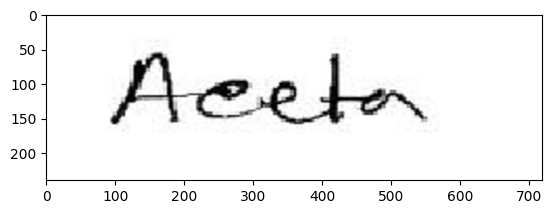

In [11]:
plt.imshow(train_images[0], cmap = "gray")

In [12]:
print("Example label:", train_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Validation data

#### validation Labels

In [13]:
validation_path = "./Dataset/Validation"
validation_labels = pd.read_csv(os.path.join(validation_path,"validation_labels.csv"), delimiter = ",")

In [14]:
validation_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medicine name

In [15]:
validation_name_enc = to_categorical(medicine_enc.transform(validation_labels["MEDICINE_NAME"]), num_classes=78)
# validation_labels["MEDECINE_NAME_ENC"] = validation_name_enc

In [16]:
len(validation_labels["MEDICINE_NAME"].unique())

78

#### Validation Images

In [17]:
validation_images = []
# validation_labels_enc = []
validation_files = glob.glob("./Dataset/Validation/validation_words/*.png")
for idx, picture in enumerate(validation_files):
    image = Image.open(picture).convert("RGB").resize((img_width, img_height))
    enhancer = ImageEnhance.Contrast(image)

    validation_images.append(np.asarray(image))
    # validation_labels_enc.append(validation_name_enc[idx])

    # validation_images.append(np.asarray(enhancer.enhance(2))) # 2 contrast
    # validation_labels_enc.append(validation_name_enc[idx])
    
    # plt.imshow(image, cmap = "gray")
    # plt.show()

# validation_images = np.array(validation_images).astype("float16")/255
validation_images = np.array(validation_images).astype("uint8")
# tf.keras.utils.image_dataset_from_directory(
#     "./Dataset/Validation/validation_words",
#     image_size = (img_height, img_width),
#     batch_size = batch_size
# )
# validation_labels_enc = np.array(validation_labels_enc)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_name_enc))
validation_dataset = validation_dataset.batch(batch_size)

In [18]:
print("Dataset shape:", validation_images.shape)
print("Labels shape:", validation_name_enc.shape)

Dataset shape: (780, 240, 720, 3)
Labels shape: (780, 78)


##### Check if it is correct

In [19]:
validation_images[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

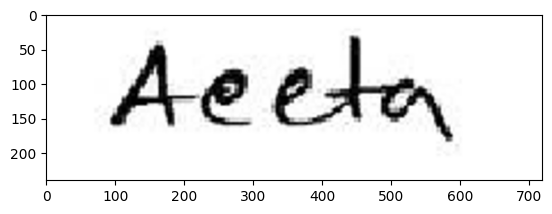

In [20]:
plt.imshow(validation_images[0], cmap = "gray")

In [21]:
print("Example label:", validation_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Test data

#### Test Labels

In [22]:
test_path = "./Dataset/Testing"
test_labels = pd.read_csv(os.path.join(test_path,"testing_labels.csv"), delimiter = ",")

In [23]:
test_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medicine name

In [24]:
test_name_enc = to_categorical(medicine_enc.transform(test_labels["MEDICINE_NAME"]), num_classes=78)
# test_labels["train_medecine_name_enc"] = test_name_enc

In [25]:
len(test_labels["MEDICINE_NAME"].unique())

78

#### Testing Images

In [26]:
test_images = []
test_labels_enc = []
test_files = glob.glob("./Dataset/Validation/validation_words/*.png")
for idx, picture in enumerate(test_files):
    image = Image.open(picture).convert("RGB").resize((img_width, img_height))
    enhancer = ImageEnhance.Contrast(image)

    test_images.append(np.asarray(image))
    test_labels_enc.append(validation_name_enc[idx])

    # test_images.append(np.asarray(enhancer.enhance(2))) # 2 contrast
    # test_labels_enc.append(validation_name_enc[idx])
    
    # plt.imshow(image, cmap = "gray")
    # plt.show()
# test_images = np.array(test_images).astype("float16")/255
test_images = np.array(test_images).astype("uint8")

# test_images = tf.keras.utils.image_dataset_from_directory(
#     "./Dataset/Validation/validation_words",
#     image_size = (img_height, img_width),
#     batch_size = batch_size
# )

test_labels_enc = np.array(test_labels_enc)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels_enc))
test_dataset = test_dataset.batch(batch_size)

In [27]:
print("Dataset shape:", test_images.shape)
print("Labels shape:", test_labels_enc.shape) 

Dataset shape: (780, 240, 720, 3)
Labels shape: (780, 78)


In [28]:
test_images

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

##### Check if it is correct

In [29]:
test_images[0].shape

(240, 720, 3)

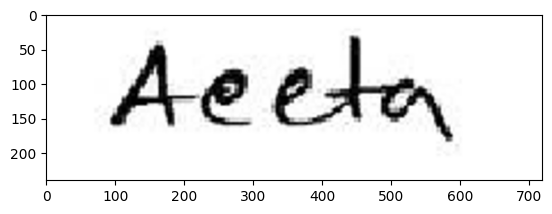

In [30]:
plt.imshow(test_images[0])

In [31]:
print("Example label:", test_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


## Building the artificial neural network

#### Getting the shape of the input

#### Make a model create function

##### Parameters for the model

In [32]:
#number of classes to determine how many neurons are in the output layer
num_classes = len(train_labels["MEDICINE_NAME"].unique())
num_classes

78

In [33]:
#the image size to determine the shape for the convolutional neural network to scan
train_images[0].shape

(240, 720, 3)

#### Create F1 Score validation function

In [34]:
# Custom F1-score metric
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Convert probabilities to binary (0 or 1)
    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)  # Average F1-score across classes

#### Create a model builder for gridsearch

the even filter shapes aren't recommended because it lacks the ability to devide the previous layer pixels arould the output pixel <a hre = "https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15">(Pandey, 2020)</a>.

<a href = "https://medium.com/@nerdjock/convolutional-neural-network-lesson-9-activation-functions-in-cnns-57def9c6e759">Machine Learning in Plain English (2023)</a> The most common activation functions are "relu" and "leaky relu" therefore we would pass it in the grid search.

Max pooling excells in image classification, due to how max pooling captures the most prominent features and reduce the variance of the input <a href = "https://www.linkedin.com/advice/1/how-do-you-choose-appropriate-pooling-method-2uvmc#adaptive-pooling">(Awad et. al, n.d.)</a>.

In [35]:
def create_model(hp):
    input_shape = (img_height, img_width, 3)
    model = Sequential()
    metrics = [
        'accuracy', 
        Precision(name = 'precision'),
        Recall(name = 'recall'),
        # f1_score
    ]
    
    #input layer. The shape of the input layer must be huge to scale down the image. Ideally (5x5) or (7x7)
    model.add(layers.Conv2D(filters = hp.Choice("input_filter", [32, 64, 128]),
                            kernel_size = hp.Choice("input_kernel_size", [5, 7, 9]),
                            activation = hp.Choice("input_activation", ["relu", "leaky_relu"]),
                            input_shape = input_shape))
    model.add(layers.MaxPooling2D(pool_size=2))
    

    #Convolutional layer
    for i in range(hp.Choice("n_conv_layers", [2, 4])):
        model.add(layers.Conv2D(filters = hp.Choice(f"conv_filter_{i}", [32, 64]),
                            kernel_size = hp.Choice(f"conv_kernel_size_{i}", [3, 5, 7, 9]),
                            activation = hp.Choice(f"conv_activation_{i}", ["relu", "leaky_relu"])))
        if i < 1:
            model.add(layers.MaxPooling2D(pool_size=2))
        
        # Add Dropout layer after each convolutional layer
        # model.add(layers.Dropout(rate=hp.Float(f"dropout_conv_{i}", 0.2, 0.5, step=0.1, default=0.25)))
        
    #Flatten the resulted image so that the dense layer could extract the patterns and categorize it
    model.add(layers.Flatten())
    
    #Building the dense layers
    for i in range(hp.Int("n_dense_layer", 1, 2, step = 1, default = 1)):
        model.add(layers.Dense(hp.Choice(f"n_neurons_dense_{i}", [128, 256]), 
                            activation = hp.Choice(f"dense_activation{i}", ["relu", "leaky_relu"])))
        
    # Add Dropout layer after dense layer
    # model.add(layers.Dropout(rate=hp.Float(f"dropout_dense_{i}", 0.2, 0.5, step=0.1, default=0.25)))

    #Output layer
    #there are 78 classes in the output layer so we will take 78 neurons to classify it
    model.add(layers.Dense(78, activation = "softmax"))
    
    # model.compile(optimizer = hp.Choice(f"optimizer", ["Adagrad", 'Adamax', 'Adadelta', 'SGD']), metrics = metrics, loss = "categorical_crossentropy")

    # GPU Optimized optimizers
    optimizer_name = hp.Choice('optimizer', ['sgd', 'rmsprop'])

    # if optimizer_name == 'adamw':
    #     optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01]), weight_decay=1e-4)
    if optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [0.00001, 0.0001, 0.001]), momentum=0.9)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001]), rho=0.9)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    
    return model

In this project, a hyperband gridsearch will be used since the hyperband tuner will stop training the model if the accuracy is low on the validation data <a href = "https://medium.com/analytics-vidhya/automated-hyperparameter-tuning-with-keras-tuner-and-tensorflow-2-0-31ec83f08a62#:~:text=Overview%20of%20available%20Keras%20Tuners,Tuners%20available%2C%20as%20of%20now.&text=The%20basic%20and%20least%20efficient,from%20a%20search%20space%20randomly.&text=A%20Hyperband%20tuner%20is%20an,accuracy%20on%20the%20validation%20set.&text=Bayesian%20Optimization%20works%20the%20same,Keras%20Tuner%20with%20the%20Documentation.">(Bag, 2021)</a>. 

In [36]:
tuner = keras_tuner.Hyperband(
    hypermodel = create_model,
    # objective="val_f1_score",
    # objective=keras_tuner.Objective("val_f1_score", direction="min"),
    # objective=keras_tuner.Objective("recall", direction="min"),
    objective = "accuracy",
    max_epochs = 500,
    factor = 5,
    hyperband_iterations = 1, #the number of iterations that the model will go trough the hyperband algorithm
    seed = 42, #for reproducibility
    distribution_strategy = tf.distribute.MirroredStrategy(), # this is to speed up the process by distributing the load for computation (only for gpu)
    # directory = "model_train_log", #to store logs on the trial results
    project_name = "medzy-train"
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


#### Create custom training loop with Gradient Accumulation

In [37]:
def train_with_accumulation(model, train_dataset, optimizer, accumulation_steps):
    # Create variables to store accumulated gradients
    accumulated_gradients = [
        tf.Variable(tf.zeros_like(var), trainable=False)
        for var in model.trainable_variables
    ]

    @tf.function
    def train_step(images, labels, step_num):
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = model.loss(labels, predictions) # Use model.loss
            loss = loss / accumulation_steps # Scale loss

        gradients = tape.gradient(loss, model.trainable_variables)

        # Accumulate gradients
        for i in range(len(accumulated_gradients)):
            accumulated_gradients[i].assign_add(gradients[i])

        # Apply accumulated gradients every accumulation_steps
        if (step_num + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))

            # Reset accumulated gradients
            for i in range(len(accumulated_gradients)):
                accumulated_gradients[i].assign(tf.zeros_like(model.trainable_variables[i]))

    # Training loop
    step_num = 0
    for images, labels in train_dataset:
        train_step(images, labels, step_num)
        step_num += 1

# 9. Custom Tuner Callback for Training
class CustomTunerCallback(keras.callbacks.Callback):
    def __init__(self, img_height, img_width, train_images, train_labels, val_images, val_labels, accumulation_steps, batch_size, num_classes):
        super().__init__()
        self.img_height = img_height
        self.img_width = img_width
        self.train_images = train_images
        self.train_labels = train_labels
        self.val_images = val_images
        self.val_labels = val_labels
        self.accumulation_steps = accumulation_steps
        self.batch_size = batch_size
        self.num_classes = num_classes

    def on_epoch_begin(self, epoch, logs=None):
        # Recreate the datasets inside the callback
        train_dataset = tf.data.Dataset.from_tensor_slices((self.train_images, self.train_labels))
        train_dataset = train_dataset.batch(self.batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((self.val_images, self.val_labels))
        val_dataset = val_dataset.batch(self.batch_size)

        # Get the current model and optimizer from the trial
        trial = self.model.tuner.oracle.get_trial(self.model.tuner.trial_id)
        model = self.model.tuner.hypermodel.build(trial.hyperparameters)
        optimizer = model.optimizer # Get the optimizer from the compiled model

        # Train the model using the custom training loop
        train_with_accumulation(model, train_dataset, optimizer, self.accumulation_steps)

        # Evaluate the model on the validation set (if available)
        if self.validation_data:
            loss, accuracy, precision, recall = model.evaluate(val_dataset)
            logs['val_loss'] = loss
            logs['val_accuracy'] = accuracy
            logs['val_precision'] = precision
            logs['val_recall'] = recall

# 10. Prepare Data for the Callback
# Convert datasets back to NumPy arrays for passing to the callback
val_images = []
val_labels = []
for images, labels in validation_dataset.unbatch().as_numpy_iterator():
    val_images.append(images)
    val_labels.append(labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

train_images_full = []
train_labels_full = []
for images, labels in train_dataset.unbatch().as_numpy_iterator():
    train_images_full.append(images)
    train_labels_full.append(labels)
train_images_full = np.array(train_images_full)
train_labels_full = np.array(train_labels_full)

#### Start the grid search

In [38]:
validation_steps = len(validation_images) #the number of validation for number of batches
accumulation_steps = 4

tuner.search(
    train_dataset,
    epochs = 500,
    validation_data = validation_dataset, #data used to evaluate the model after each epoch
    validation_steps = validation_steps, #number of batches used for validation
    callbacks = [
        keras.callbacks.EarlyStopping("accuracy")
        # keras.callbacks.EarlyStopping("recall", mode="max")
    ]
    # callbacks=[CustomTunerCallback(img_height, img_width, train_images_full, train_labels_full, val_images, val_labels, accumulation_steps, batch_size, num_classes)],
)

Trial 10 Complete [00h 01m 29s]
accuracy: 0.012820512987673283

Best accuracy So Far: 0.1448718011379242
Total elapsed time: 00h 11m 25s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
128               |32                |input_filter
7                 |7                 |input_kernel_size
relu              |relu              |input_activation
2                 |2                 |n_conv_layers
32                |32                |conv_filter_0
5                 |9                 |conv_kernel_size_0
leaky_relu        |relu              |conv_activation_0
32                |32                |conv_filter_1
3                 |5                 |conv_kernel_size_1
relu              |relu              |conv_activation_1
1                 |1                 |n_dense_layer
256               |256               |n_neurons_dense_0
leaky_relu        |leaky_relu        |dense_activation0
rmsprop           |rmsprop           |optimizer
0.001             |1e-05  

KeyboardInterrupt: 